## UCI Bike Sharing Dataset

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare, ttest_ind

import itertools

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [5]:
hrsdf = pd.read_csv('../data/hour.csv')
daysdf = pd.read_csv('../data/day.csv')

## Analysis Using Days Data

In [6]:
daysdf.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


No missing entries and all datatypes seem to match the variable appropriately so we don't need to worry about any weird values that might represent nulls

In [7]:
daysdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [8]:
daysdf.groupby('weekday').size()

weekday
0    105
1    105
2    104
3    104
4    104
5    104
6    105
dtype: int64

Comparing the distributions of rental counts between each day of the week, there's not a single day that pops out that might have more or less rentals than other days. 

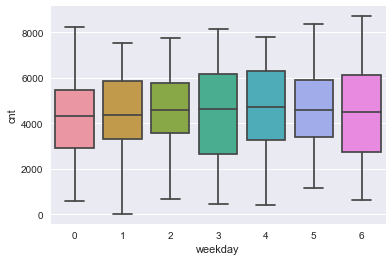

In [9]:
sns.boxplot(x = daysdf['weekday'], y = daysdf['cnt'])

Comparing months on the otherhand, it appears that rentals increase as the year progresses into spring and summer then starts to decrease again when fall and winter months approach. 

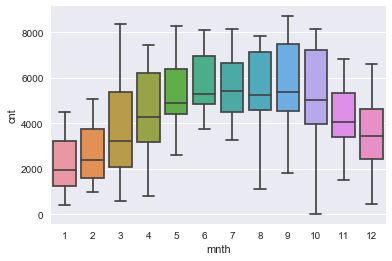

In [10]:
sns.boxplot(x = daysdf['mnth'], y = daysdf['cnt'])

But, let's not make conclusions based off of only what we see...

Since there are 12 months to compare, it doesn't make sense to do 66 (12 choose 2) pairwise comparisons that would most likely always cause us to fail to reject the null if we were to use the Bonferroni correction. I will later use some pairwise hypothesis tests with significance level corrections for some other comparisons. For comparing the months, however, I will use the Chi-Squared test to see if there's statistical significance in higher rentals during the middle of the year than the tails as we saw in the graph above.

If there were no months that had more rentals than others, we would expect that the number of rentals would be around the same each month. Assuming the rental count per month is the same, we want to calculate how likely it is, or the probability, of getting the total counts per month that we observed by chance. Luckily the Chi-Squared test does this all for us. 

Using Scipy's chisquare function, the calculated p-value is 0. That is, if rental count was the same per month, seeing what we saw in the prior graph above would have been an extremely unlikely observation. So we can say with statistical significance that rental counts increase through the first half of the year then start decrease again during the second half.

In [11]:
rentals_per_month = daysdf.groupby('mnth')['cnt'].sum()
chisquare(rentals_per_month)

Power_divergenceResult(statistic=247249.3223332733, pvalue=0.0)

Great. Since we saw an increase in bike rentals during summer months, let's look into and compare the total rentals per season in the two years and see if there's any significance there.

According to the info accompanying the dataset, the mapping of the values in the season column is as follows: 
<br>1 is Spring, 2 is Summer, 3 is Fall, and 4 is Winter

However, I don't think this mapping is correct. Looking at entries in 'winter', 'spring', 'summer', and 'fall' months, I believe 1 is Winter, 2 is Spring, 3 is Summer, and 4 is Fall. I've contacted the person listed as point of contact for this dataset to confirm but for now, I will assume that this is the correct maping

In [12]:
print(daysdf[daysdf['dteday'] == '2011-01-15']['season'])
print(daysdf[daysdf['dteday'] == '2011-04-15']['season'])
print(daysdf[daysdf['dteday'] == '2011-07-15']['season'])
print(daysdf[daysdf['dteday'] == '2011-10-15']['season'])

14    1
Name: season, dtype: int64
104    2
Name: season, dtype: int64
195    3
Name: season, dtype: int64
287    4
Name: season, dtype: int64


Ok, if the mapping I stated above is correct, I can say what I was going to say! 

As expected, rentals during the winter season seem to more inactive than the other three seasons. Or at least that's what we have observed...

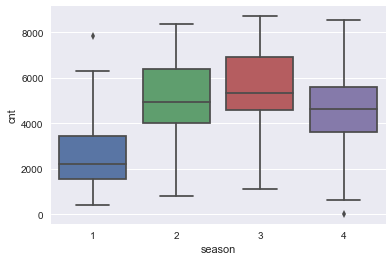

In [13]:
sns.boxplot(x = daysdf['season'], y = daysdf['cnt'])

It's a little hard to tell if there will be any significant difference between non-winter seasons. Since 6 (4 choose 2) pairwise comparisons isn't too daunting, I'm going to perform 6 separate hypothesis tests. For each test, the null hypothesis will be that the mean rental counts between the two seasons is the same and the alternative hypothesis will be that the mean rental counts are not the same, giving us a two-tailed test.

Our assumptions in regards to the Central Limit Theorem are met. That is, our sample sizes for each season are greater than 30 so the distributions of our means should approximately follow the Normal Distribution. Since scipy makes it easy for us, I'm still going to use the built in t-test to compare the means (with a large enough sample size, the t-test is basically a z-test). 

Lastly, Because the chances of making a Type I (false positive) error increases, we want to make a correction to our significance level based off how many tests we're doing. The Bonferroni Correction is a very conservative correction but since we have 6 tests, our adjusted significance level won't be cut down drastically. 

In [14]:
daysdf.groupby('season').size()

season
1    181
2    184
3    188
4    178
dtype: int64

Using the Bonferroni Correction, there's statistical significance in mean rental differences between seasons for each pair except for between Spring and Fall.

In [15]:
seasons = [1, 2, 3, 4]
season_pairs = itertools.combinations(seasons, 2)
sign_level = 0.05 / 6

for pair in season_pairs:
    season_1 = pair[0]
    season_2 = pair[1]
    s1_vals = daysdf[daysdf['season'] == season_1]['cnt']
    s2_vals = daysdf[daysdf['season'] == season_2]['cnt']
    
    t_stat, p_val = ttest_ind(s1_vals, s2_vals)
    
    if p_val < sign_level:
        print('Difference in mean rental counts between season {} and season {} is statistically significant with p-value = {}'\
                  .format(str(season_1), str(season_2), p_val))
        
    else:
        print('Difference in mean rental counts between season {} and season {} is NOT statistically significant with p-value = {}' \
                  .format(str(season_1), str(season_2), p_val))


Difference in mean rental counts between season 1 and season 2 is statistically significant with p-value = 1.52848222714e-38
Difference in mean rental counts between season 1 and season 3 is statistically significant with p-value = 2.13407296852e-62
Difference in mean rental counts between season 1 and season 4 is statistically significant with p-value = 1.20220671752e-31
Difference in mean rental counts between season 2 and season 3 is statistically significant with p-value = 8.41150981151e-05
Difference in mean rental counts between season 2 and season 4 is NOT statistically significant with p-value = 0.139742317895
Difference in mean rental counts between season 3 and season 4 is statistically significant with p-value = 5.7789091515e-08


Let's look at if there's a difference in rentals between workdays (1) vs not a workday (0, defined as a weekend or a holiday). We have enough workday and non-workday samples to conduct z-test but again will use Scipy's t-test.

In [16]:
daysdf.groupby('workingday').size()

workingday
0    231
1    500
dtype: int64

Doesn't look too different...

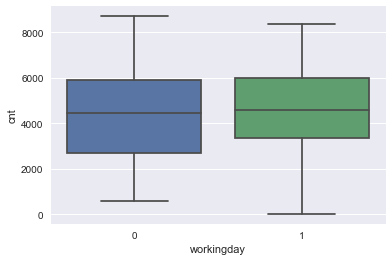

In [17]:
sns.boxplot(x = daysdf['workingday'], y = daysdf['cnt'])

Performing the hypothesis test, there is not a statistical significance between the number of bikes rented on workdays vs. non-workdays

In [18]:
s1 = daysdf[daysdf['workingday'] == 1]['cnt']
s2 = daysdf[daysdf['workingday'] == 0]['cnt']

t_stat, p_val = ttest_ind(s1, s2)
print(p_val)

0.0984949616002


## Event Detection

The description included with the data points out using the data for event detection. Even though there's information from 2011 and 2012, I did some quick research on big weather-related events that occurred in the area in and around Washington D.C. in 2012. 

Here are the top 5 weather events that happened:

1: March had record warmth with temperatures frequently reaching 70's and 80's (pretty good biking weather!)
<br>2: Tornado outbreak on June 1 (12 total)
<br>3: Superstorm / Hurricane Sandy in Late October
<br>4: More record heat in July (is there a peak in temperatures where it gets too hot and deters people from renting bikes?)
<br>5: June 29 derecho (never heard of but apparently is a line of storms)

I'm going to look at a couple of these events - numbers 2 and 4...

In [19]:
days_12 = daysdf[daysdf['yr'] == 1]
days_12.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
365,366,2012-01-01,1,1,1,0,0,0,1,0.370000,0.375621,0.692500,0.192167,686,1608,2294
366,367,2012-01-02,1,1,1,1,1,0,1,0.273043,0.252304,0.381304,0.329665,244,1707,1951
367,368,2012-01-03,1,1,1,0,2,1,1,0.150000,0.126275,0.441250,0.365671,89,2147,2236
368,369,2012-01-04,1,1,1,0,3,1,2,0.107500,0.119337,0.414583,0.184700,95,2273,2368
369,370,2012-01-05,1,1,1,0,4,1,1,0.265833,0.278412,0.524167,0.129987,140,3132,3272


### Tornado outbreak on June 1

There's definitely a low peak on June 1. Even though there were some other drops in the middle and at the end of the month (might want to look into if there were any events in D.C. that happened to cause these decreases) June 1st definitely had the least rentals in the whole month. 

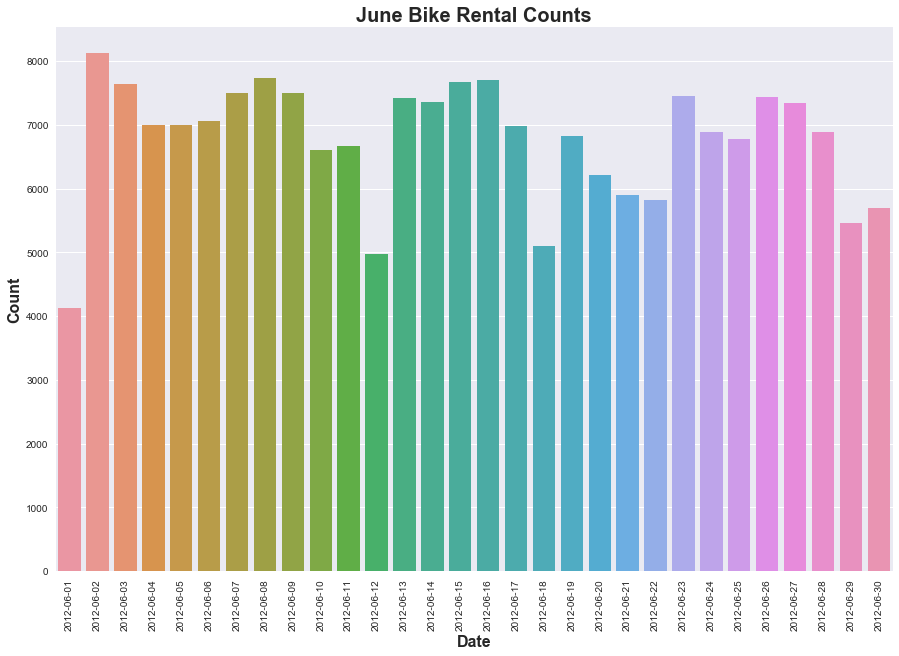

In [33]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
sns.barplot(x = days_12[days_12['mnth'] == 6]['dteday'], y = days_12[days_12['mnth'] == 6]['cnt'])
plt.title('June Bike Rental Counts', fontdict = {'fontsize':20, 'fontweight':'bold'})
plt.xlabel('Date', fontdict = {'fontsize':16, 'fontweight':'bold'})
plt.ylabel('Count', fontdict = {'fontsize':16, 'fontweight':'bold'})

### Record heat in July

Comparing July to what we saw in June and also to rentals in August, to the naked eyed it looks like there's a lot more variability in count during the hot month. August seems pretty variable too but that variability is more structured; rentals increase, experience a drop and increase again, and this happens multiple times during the month. 

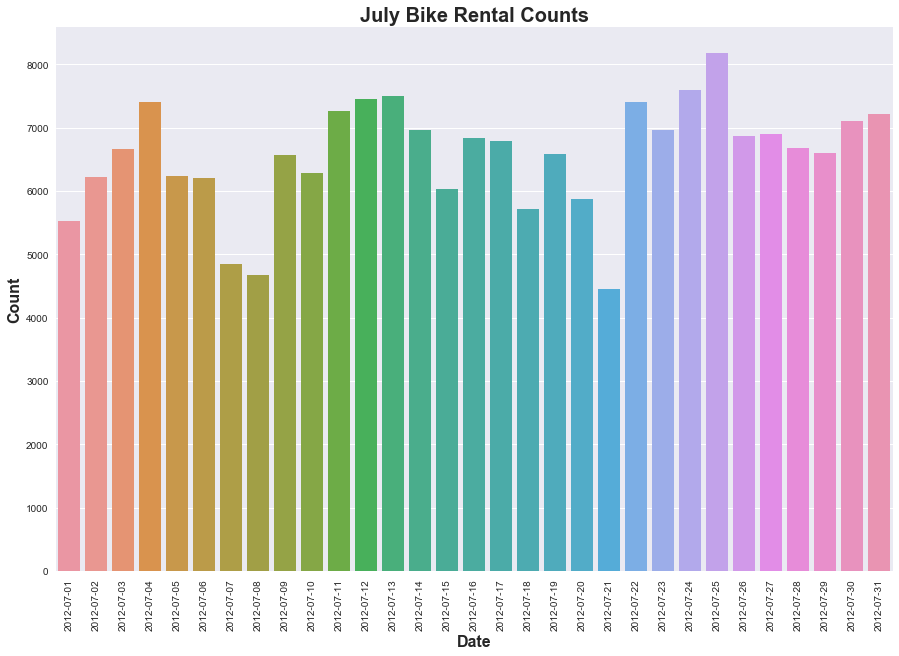

In [34]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
sns.barplot(x = days_12[days_12['mnth'] == 7]['dteday'], y = days_12[days_12['mnth'] == 7]['cnt'])
plt.title('July Bike Rental Counts', fontdict = {'fontsize':20, 'fontweight':'bold'})
plt.xlabel('Date', fontdict = {'fontsize':16, 'fontweight':'bold'})
plt.ylabel('Count', fontdict = {'fontsize':16, 'fontweight':'bold'})

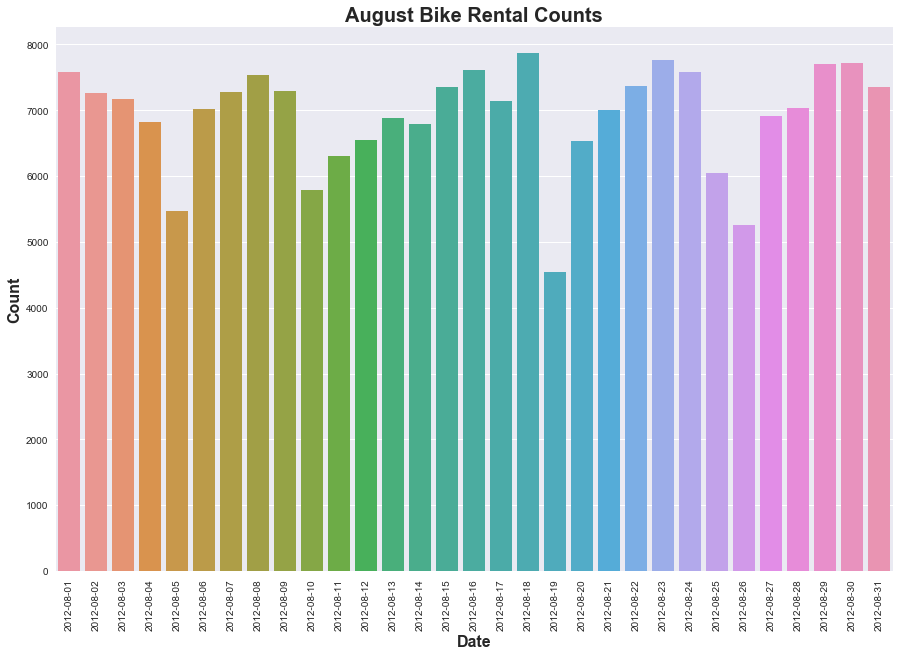

In [35]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
sns.barplot(x = days_12[days_12['mnth'] == 8]['dteday'], y = days_12[days_12['mnth'] == 8]['cnt'])
plt.title('August Bike Rental Counts', fontdict = {'fontsize':20, 'fontweight':'bold'})
plt.xlabel('Date', fontdict = {'fontsize':16, 'fontweight':'bold'})
plt.ylabel('Count', fontdict = {'fontsize':16, 'fontweight':'bold'})

July also has the smallest mean rental count out of June, July, and August. I'm curious now if higher temperatures increase rentals to a certain point and starts to go down if temperatures get too warm. Another explaination in drop in July rentals is that it's a summer month when kids and families might be doing other activities other than biking.

In [23]:
days_12[(days_12['mnth'] == 6) | (days_12['mnth'] == 7) | (days_12['mnth'] == 8)].groupby('mnth')['cnt'].mean()

mnth
6    6761.000000
7    6567.967742
8    6919.451613
Name: cnt, dtype: float64

In [24]:
days_12[(days_12['mnth'] == 6) | (days_12['mnth'] == 7) | (days_12['mnth'] == 8)].groupby('mnth')['atemp'].mean()

mnth
6    0.629932
7    0.697528
8    0.647534
Name: atemp, dtype: float64

There are some outliers present that might need to be addressed, especially the point with a zero count, but there's a clear relationship between temperature and rentals - higher temperatures lead to more rentals. 

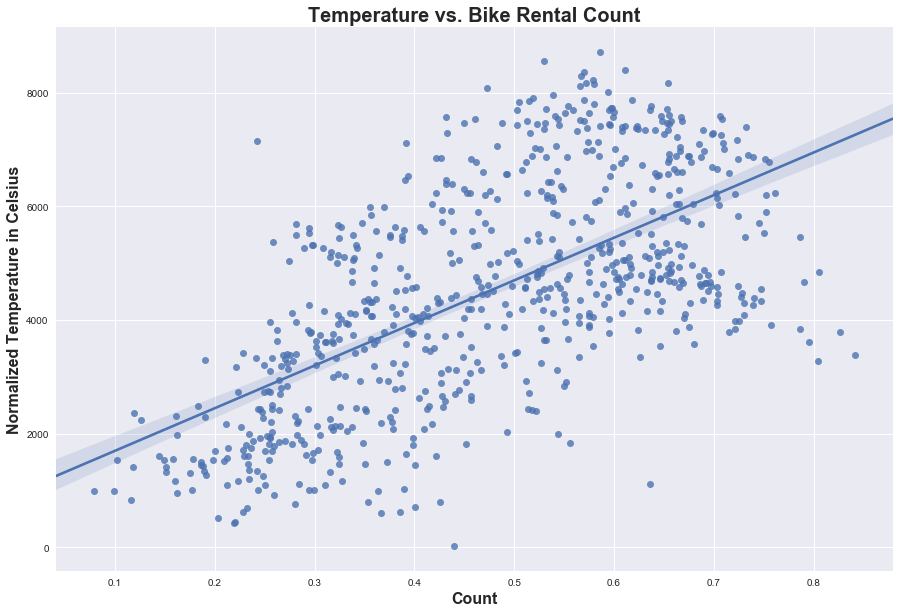

In [36]:
plt.figure(figsize = (15, 10))
sns.regplot(x = daysdf['atemp'], y = daysdf['cnt'])
plt.title('Temperature vs. Bike Rental Count', fontdict = {'fontsize':20, 'fontweight':'bold'})
plt.xlabel('Count', fontdict = {'fontsize':16, 'fontweight':'bold'})
plt.ylabel('Normalized Temperature in Celsius', fontdict = {'fontsize':16, 'fontweight':'bold'})

Looking at 2011, July appeared to have a heat wave too, which I confirmed with some quick research. However, we don't see the drop in rental count for the month like what happened in 2012. 

It would be nice to have more years represented in the data to see if temperature is a driving factor for bike rental counts or if there are other seasonal factors that we might need to take into consideration. 

In [26]:
days_11 = daysdf[daysdf['yr'] == 0]
days_11[(days_11['mnth'] == 6) | (days_11['mnth'] == 7) | (days_11['mnth'] == 8)].groupby('mnth')['cnt'].mean()

mnth
6    4783.733333
7    4559.387097
8    4409.387097
Name: cnt, dtype: float64

In [28]:
days_11[(days_11['mnth'] == 6) | (days_11['mnth'] == 7) | (days_11['mnth'] == 8)].groupby('mnth')['atemp'].mean()

mnth
6    0.646559
7    0.710660
8    0.655415
Name: atemp, dtype: float64